# Lesson 4: Basic scan (& plot) of scaler *vs.* motor


**Preparation**

*`instrument` package*

Make sure the `instrument` package is in the same directory 
as this jupyter notebook. The `instrument` package included with 
this lesson is a brief version of the standard package used 
with any APS instrument.  Since the notebook is for teaching,
it does not connect with any mongodb database.  The scans are 
not kept by the databroker.  However, every scan is saved to a 
SPEC data file as described when the instrument package is loaded.

In [1]:
from instrument.collection import *

I Thu-15:04:20 - ############################################################ startup
I Thu-15:04:20 - logging started
I Thu-15:04:20 - logging level = 10
I Thu-15:04:20 - /home/beams1/JEMIAN/Documents/projects/use_bluesky/lessons/instrument/collection.py
I Thu-15:04:20 - /home/beams1/JEMIAN/Documents/projects/use_bluesky/lessons/instrument/mpl/notebook.py


Activating auto-logging. Current session state plus future input saved.
Filename       : /home/beams1/JEMIAN/Documents/projects/use_bluesky/lessons/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Thu-15:04:20 - bluesky framework
I Thu-15:04:20 - /home/beams1/JEMIAN/Documents/projects/use_bluesky/lessons/instrument/framework/check_python.py
I Thu-15:04:20 - /home/beams1/JEMIAN/Documents/projects/use_bluesky/lessons/instrument/framework/check_bluesky.py
I Thu-15:04:22 - /home/beams1/JEMIAN/Documents/projects/use_bluesky/lessons/instrument/framework/initialize.py
I Thu-15:04:26 - /home/beams1/JEMIAN/Documents/projects/use_bluesky/lessons/instrument/framework/metadata.py
I Thu-15:04:26 - /home/beams1/JEMIAN/Documents/projects/use_bluesky/lessons/instrument/framework/callbacks.py
I Thu-15:04:26 - writing to SPEC file: /home/beams1/JEMIAN/Documents/projects/use_bluesky/lessons/20200507-150426.dat
I Thu-15:04:26 -    >>>>   Using default SPEC file name   <<<<
I Thu-15:04:26 -    file will be created when bluesky ends its next scan
I Thu-15:04:26 -    to change SPEC file, use command:   newSpecFile('title')


get a motor and scaler from the ophyd simulators

In [2]:
from ophyd.sim import motor as m1
from ophyd.sim import det as scaler

scan the scaler *v.* the motor



Transient Scan ID: 1     Time: 2020-05-07 15:04:30
Persistent Unique Scan ID: '74ceb4be-f319-45ac-8ac9-6b9086c752d0'
New stream: 'primary'


<IPython.core.display.Javascript object>


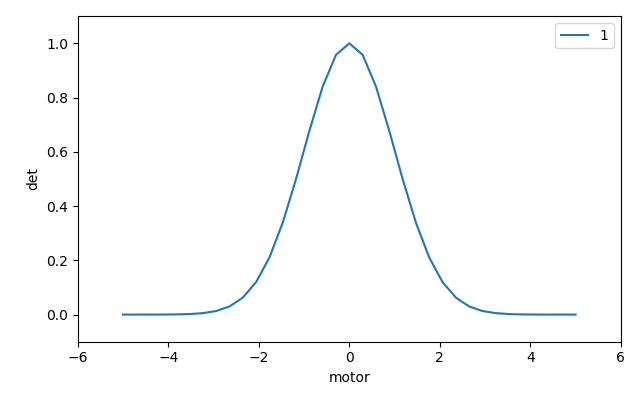

+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+
|         1 | 15:04:30.6 |     -5.000 |      0.000 |
|         2 | 15:04:30.6 |     -4.706 |      0.000 |
|         3 | 15:04:30.6 |     -4.412 |      0.000 |
|         4 | 15:04:30.6 |     -4.118 |      0.000 |
|         5 | 15:04:30.6 |     -3.824 |      0.001 |
|         6 | 15:04:30.6 |     -3.529 |      0.002 |
|         7 | 15:04:30.6 |     -3.235 |      0.005 |
|         8 | 15:04:30.6 |     -2.941 |      0.013 |
|         9 | 15:04:30.6 |     -2.647 |      0.030 |
|        10 | 15:04:30.6 |     -2.353 |      0.063 |
|        11 | 15:04:30.7 |     -2.059 |      0.120 |
|        12 | 15:04:30.7 |     -1.765 |      0.211 |
|        13 | 15:04:30.7 |     -1.471 |      0.339 |
|        14 | 15:04:30.7 |     -1.176 |      0.501 |
|        15 | 15:04:30.7 |     -0.882 |      0.678 |
|        16 | 15:04:30.7 |     -0.588 |      0

('74ceb4be-f319-45ac-8ac9-6b9086c752d0',)

In [3]:
RE(bp.scan([scaler], m1, -5, 5, 35))